In [ ]:
# %pip install --upgrade pip FLAML "flaml[spark]" shap setuptools wheel optuna optuna-integration openml xgboost catboost imbalanced-learn pandas scipy statsmodels
# %pip install --upgrade "scikit-learn==1.1.2"
%pip install catboost FLAML "flaml[spark]" geopy gspread imbalanced-learn ipykernel matplotlib numpy \
    openpyxl openai openml optuna optuna-integration \
        pandas pip plotly_express polars PyCap pygsheets python-dotenv pyspark \
            seaborn scipy setuptools scikit-learn shap statsmodels tabulate tabula-py wheel xlsx2csv xgboost

In [1]:
# To allow own package to be imported
import sys
import os
if os.path.dirname(os.getcwd()) not in sys.path:
    sys.path.append(os.path.dirname(os.getcwd()))
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
from warnings import filterwarnings
filterwarnings(action = "ignore")

# import necessary packages
import pandas as pd
import numpy as np
import polars as pl
import plotly.express as px
import wh0102 as mphd

# Prepare the data dictionary
data_dictionary = {
    "Ethnic":{0:"Malay", 1:"Chinese", 2:"Indian"},
    "bmi":{0:"Normal BMI", 1:"Overweight"},
    "Disease":{0:"No liver disease", 1:"Have Liver Disease"},
    "Gender":{0:"Female", 1:"Male"}
}

normal_values = {"TP":[64, 83],
                 "ALB":[35, 52],
                 "TB":[0, 22],
                 "ALP":[40, 130],
                 "ALT":[0, 42],
                 "AST":[0, 41]}

# Rename for easier references
column_to_be_rename = {"Sgot":"ALT",
                       "Sgpt":"AST",
                       "Alkphos":"ALP"}

# Prepare the variables
dependent_variable = "Disease"
independent_demographic = ("Age", "Gender", "Ethnic", "bmi",)
independent_investigations = ("AGR", "ALB", "TP", "TB", "DB", "ALP", "ALT", "AST",)
independent_continous = (independent_demographic[0],) + independent_investigations
independent_categorical = independent_demographic[1:]
independent_variables = independent_demographic + independent_investigations

# Load the data
df = pd.read_csv(r"assignment4.csv")

# Rename the column name
df = df.rename(columns = column_to_be_rename)

# To reassign the categorical value
for column in [key for key in data_dictionary.keys() if key != "Gender"]:
    df.loc[:,column] = df.loc[:,column] - 1

# To change 0 & 1 for the bmi and disease in reverse order
for column in ["bmi", "Disease"]:
    df.loc[:,column] = df.loc[:,column].replace({0:1, 1:0})

# Print the information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553 entries, 0 to 552
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Patient_ID  553 non-null    int64  
 1   Age         553 non-null    int64  
 2   TB          553 non-null    float64
 3   DB          553 non-null    float64
 4   ALP         553 non-null    int64  
 5   ALT         553 non-null    int64  
 6   AST         553 non-null    int64  
 7   TP          553 non-null    float64
 8   ALB         553 non-null    float64
 9   AGR         553 non-null    object 
 10  Disease     553 non-null    int64  
 11  Ethnic      553 non-null    int64  
 12  Gender      553 non-null    object 
 13  bmi         553 non-null    int64  
dtypes: float64(4), int64(8), object(2)
memory usage: 60.6+ KB


In [2]:
# Convert the gender
df = mphd.categorical_data.label_encode(df = df, columns = "Gender", convert_numeric=True)
# "Gender":{0:"Female", 1:"Male"}

# Check for duplication
duplicated_df, to_drop_duplicated_df = mphd.pre_processing.check_duplication(df)

# Check for missing value
missing_df = mphd.missing_values.analyse_missing_row(df)
missing_df

No duplication found in the dataset.
Missing data detected for columns AGR.
Summary of the missing values from the dataframe =
+------------------------------+-------+--------------------+
|                              | count | missing_percentage |
+------------------------------+-------+--------------------+
|             AGR              |  4.0  |        0.72        |
| All_rows_with_missing_values |  4.0  |        0.72        |
+------------------------------+-------+--------------------+


,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi
140,141,45,0.9,0.3,189,33,23,6.6,3.9,NaN,1,0,0,1
160,161,51,0.8,0.2,230,46,24,6.5,3.1,NaN,1,0,1,1
450,451,35,0.6,0.2,180,15,12,5.2,2.7,NaN,0,2,0,0
468,469,27,1.3,0.6,106,54,25,8.5,4.8,NaN,0,0,1,1


## To fix AGR == ' ' issue

In [3]:
# Calculate the Globulin for every patient ID with globulin = tp - alb based on resource below:
# https://www.ncbi.nlm.nih.gov/books/NBK204/#:~:text=The%20total%20globulin%20fraction%20is,of%20further%20fractionating%20serum%20proteins

# To check the truthness of this on the data
# Create a deep copy of the df with AGR not null first
temp_df = df.query("AGR.notnull()").copy(deep = True)

# Calculatet the globulin and agr_ratio
def calculate_agr(df:pd.DataFrame, column_name:str):
    df.loc[:,column_name] = df.loc[:,"ALB"] / (df.loc[:,"TP"] - df.loc[:,"ALB"])
    return df

# Calculate the approximate agr
temp_df = calculate_agr(df = temp_df, column_name = "agr_new")
# Check for float similarity
temp_df.loc[:,"agr_similarity"] = temp_df.loc[:,("AGR", "agr_new",)]\
    .apply(lambda x: np.isclose(float(x[0]), x[1], rtol = 0.1), axis = 1)

# Pivot the information
pt = temp_df.pivot_table(index = "agr_similarity", values = "Patient_ID", aggfunc = len, margins = True)\
    .rename(columns={"Patient_ID":"count"})
# Calculate percentage
pt.loc[:,"percentage"] = round(pt.loc[:,"count"] / pt.loc["All", "count"] * 100, 2)

print(pt.to_markdown(tablefmt = "pretty"))

# Check on the not similarity result
temp_df.query("agr_similarity == False")

+----------------+-------+------------+
| agr_similarity | count | percentage |
+----------------+-------+------------+
|     False      | 48.0  |    8.74    |
|      True      | 501.0 |   91.26    |
|      All       | 549.0 |   100.0    |
+----------------+-------+------------+


,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi,agr_new,agr_similarity
9,10,72,2.7,1.3,260,56,31,7.4,3.0,0.6,1,0,1,0,0.681818,False
32,33,45,0.7,0.2,170,14,21,5.7,2.5,0.7,1,0,0,0,0.781250,False
49,50,75,0.8,0.2,188,29,20,4.4,1.8,0.6,1,0,0,1,0.692308,False
63,64,60,6.8,3.2,308,794,404,6.8,3.0,0.7,1,0,1,0,0.789474,False
64,65,60,8.6,4.0,298,850,412,7.4,3.0,0.6,1,0,1,1,0.681818,False
91,92,66,4.2,2.1,159,30,15,7.1,2.2,0.4,1,0,0,1,0.448980,False
130,131,60,2.4,1.0,1124,54,30,5.2,1.9,0.5,1,0,1,1,0.575758,False
133,134,7,27.2,11.8,1420,1050,790,6.1,2.0,0.4,1,0,0,1,0.487805,False
139,140,70,0.9,0.3,220,95,53,6.1,2.8,0.68,1,0,0,1,0.848485,False
164,165,55,1.8,9.0,272,79,22,6.1,2.7,0.7,1,0,1,1,0.794118,False


In [4]:
# Trial to impute with calculation
missing_df_temp = calculate_agr(df = missing_df, column_name="AGR")
missing_df_temp

,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi
140,141,45,0.9,0.3,189,33,23,6.6,3.9,1.444444,1,0,0,1
160,161,51,0.8,0.2,230,46,24,6.5,3.1,0.911765,1,0,1,1
450,451,35,0.6,0.2,180,15,12,5.2,2.7,1.08,0,2,0,0
468,469,27,1.3,0.6,106,54,25,8.5,4.8,1.297297,0,0,1,1


In [ ]:
# Impute with MissingForest
# https://betterdatascience.com/python-missforest-algorithm/#google_vignette

mf_df = mphd.missing_values.miss_forest_imputation(df=df, columns = "AGR")
# Check on the imputated value
mf_df.loc[missing_df.index]

In [5]:
# Impute with MICE
# https://medium.com/@brijesh_soni/topic-9-mice-or-multivariate-imputation-with-chain-equation-f8fd435ca91#:~:text=MICE%20stands%20for%20Multivariate%20Imputation,produce%20a%20final%20imputed%20dataset.

df = mphd.missing_values.mice_imputation(df = df, columns = "AGR")
# Check on the imputated value
df.loc[missing_df.index]

,Patient_ID,Age,TB,DB,ALP,ALT,AST,TP,ALB,AGR,Disease,Ethnic,Gender,bmi
140,141,45,0.9,0.3,189,33,23,6.6,3.9,1.299105,1,0,0,1
160,161,51,0.8,0.2,230,46,24,6.5,3.1,0.908333,1,0,1,1
450,451,35,0.6,0.2,180,15,12,5.2,2.7,1.006441,0,2,0,0
468,469,27,1.3,0.6,106,54,25,8.5,4.8,1.361591,0,0,1,1


__intepretation__:

For imputation, despite the logic of how AGR being calculated, there is a lot of noise in the data for AGR value, therefore we would use MICE for imputation.

## Continous Data

+-----------------+------------+----------+---------+---------+------------+------------+------------+---------+---------+--------+---------+---------+---------+---------+
|                 | Patient_ID |   Age    |   TB    |   DB    |    ALP     |    ALT     |    AST     |   TP    |   ALB   |  AGR   | Disease | Ethnic  | Gender  |   bmi   |
+-----------------+------------+----------+---------+---------+------------+------------+------------+---------+---------+--------+---------+---------+---------+---------+
|      count      |   553.0    |  553.0   |  553.0  |  553.0  |   553.0    |   553.0    |   553.0    |  553.0  |  553.0  | 553.0  |  553.0  |  553.0  |  553.0  |  553.0  |
|      mean       |   277.0    |  44.425  | 3.1318  |  1.462  |  286.3779  |  111.8101  |  81.4991   | 6.4801  | 3.1472  | 0.953  | 0.6926  | 0.7541  | 0.7523  |  0.642  |
|       std       |  159.7816  | 16.0055  | 5.4053  | 2.7846  |  239.5825  |  295.6858  |  186.8426  |  1.083  | 0.7888  | 0.3189 | 0.4618  

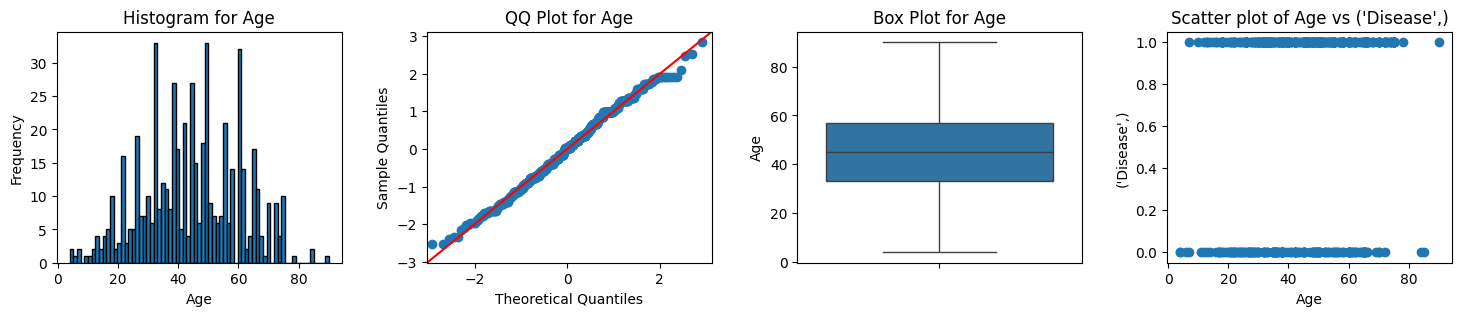

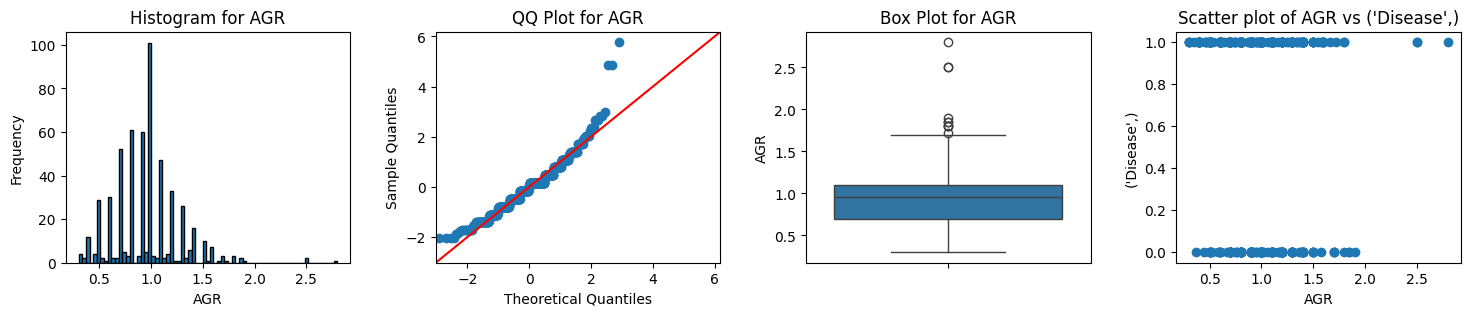

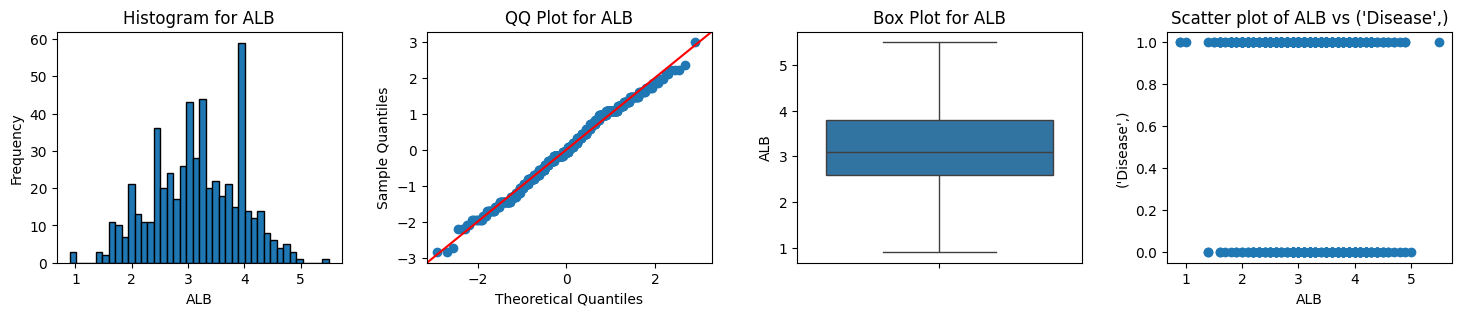

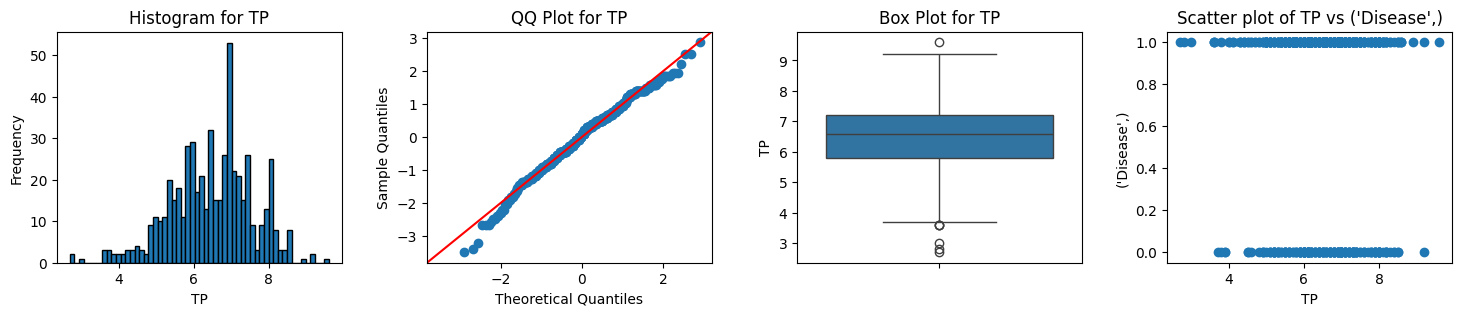

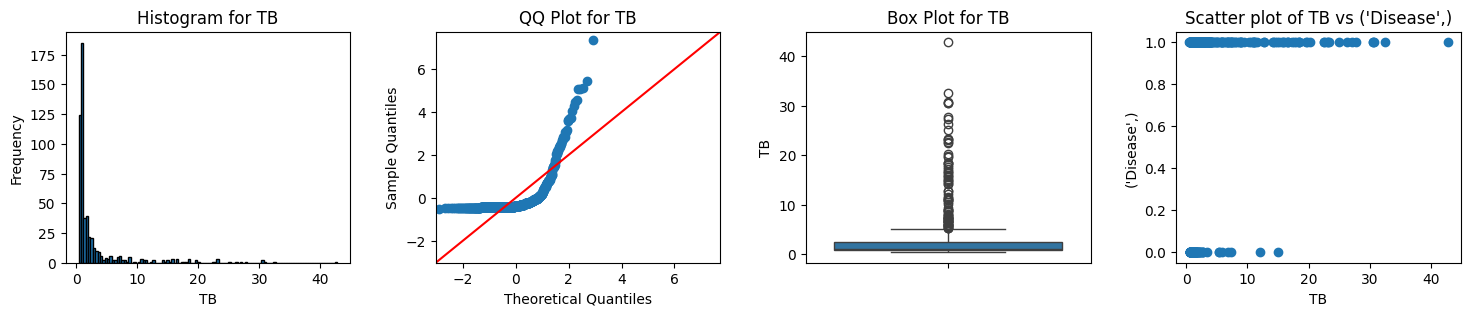

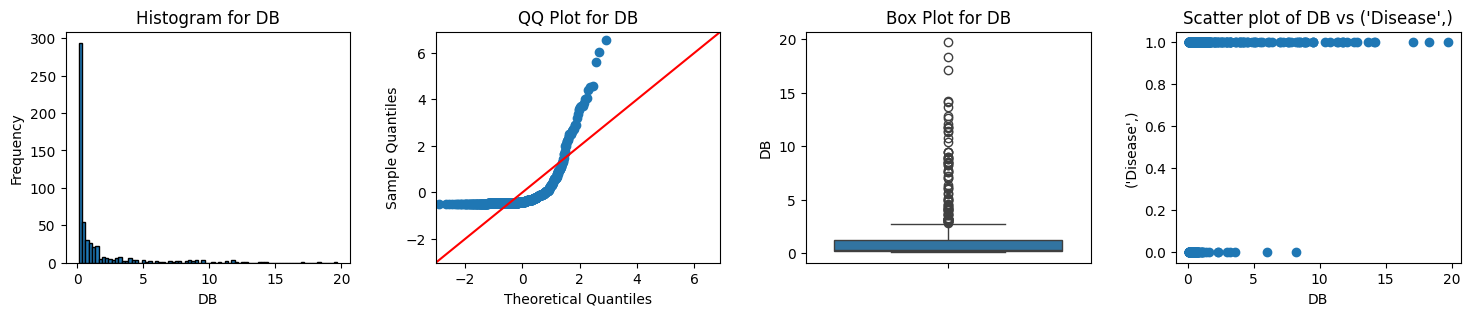

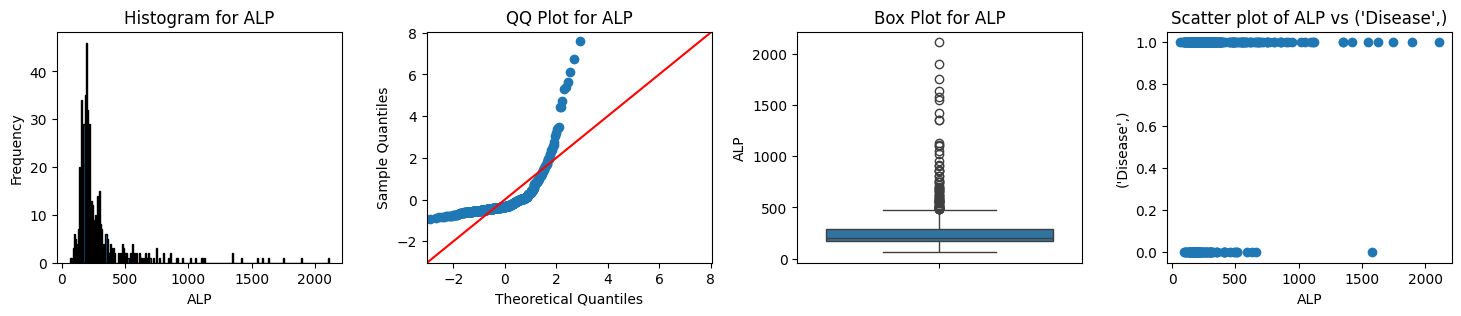

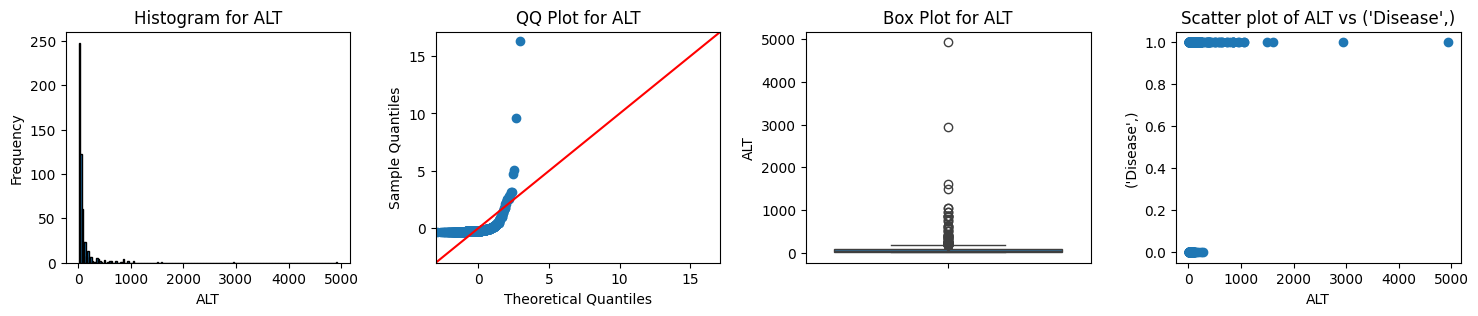

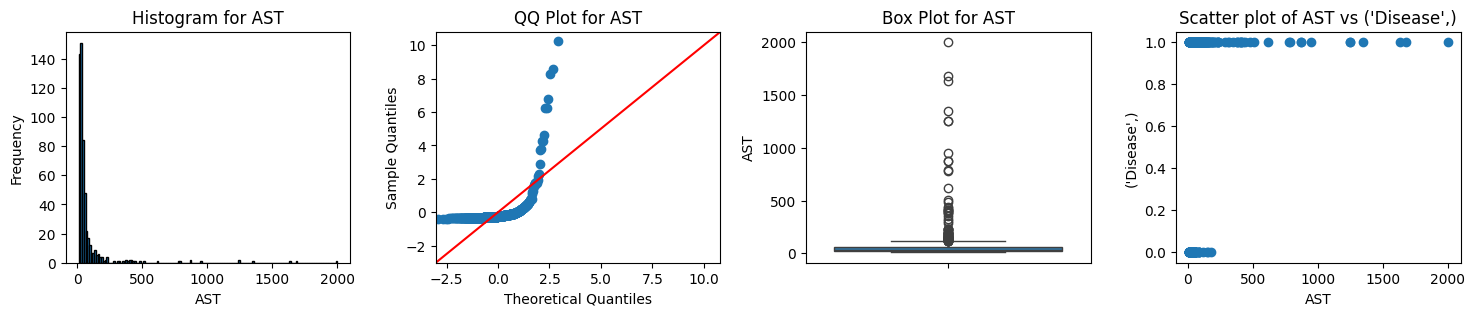

Plotting correlation matrix


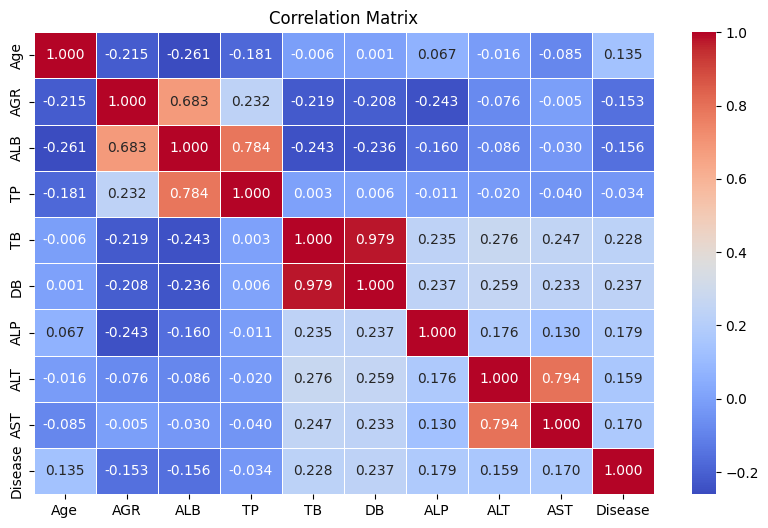

In [6]:
# Check for normal distribution
normal_distribution_list, abnormal_distribution_list = mphd.continous_data.descriptive_analysis(df = df, 
                                                                                                independent_variables=independent_continous, 
                                                                                                dependent_variables = dependent_variable,
                                                                                                descriptive_type = "continous",
                                                                                                plot_dependent_variables = False,
                                                                                                plot_correlation = True, 
                                                                                                round = 4)

In [7]:
# Show outliers with 1.5 * iqr
outliers_df = mphd.continous_data.identify_outliers(df = df, 
                                                    column_name = ["TP", "TB", "ALP", "AST", "ALT"], 
                                                    ratio = 1.5,
                                                    normal_values = normal_values)

# normal_distribution_list, abnormal_distribution_list = mphd.continous_data.descriptive_analysis(df = df.loc[~df.index.isin(outliers_df.index)], 
#                                                                                                 independent_variables=independent_continous, 
#                                                                                                 dependent_variables = dependent_variable,
#                                                                                                 descriptive_type = "continous",
#                                                                                                 plot_dependent_variables = False,
#                                                                                                 plot_correlation = True, 
#                                                                                                 round = 4)

Outliers found in column of TP with boundaries of 4.50 - 83.00:
Normal Value : 64 - 83
+-----+------------+------+------+-----+-------+-------+-------+-----+-----+------+---------+--------+--------+-----+
|     | Patient_ID | Age  |  TB  | DB  |  ALP  |  ALT  |  AST  | TP  | ALB | AGR  | Disease | Ethnic | Gender | bmi |
+-----+------------+------+------+-----+-------+-------+-------+-----+-----+------+---------+--------+--------+-----+
| 49  |    50.0    | 75.0 | 0.8  | 0.2 | 188.0 | 29.0  | 20.0  | 4.4 | 1.8 | 0.6  |   1.0   |  0.0   |  0.0   | 1.0 |
| 50  |    51.0    | 75.0 | 0.8  | 0.2 | 205.0 | 24.0  | 27.0  | 4.4 | 2.0 | 0.8  |   1.0   |  0.0   |  0.0   | 1.0 |
| 304 |   305.0    | 66.0 | 0.8  | 0.2 | 165.0 | 32.0  | 22.0  | 4.4 | 2.0 | 0.8  |   1.0   |  2.0   |  1.0   | 0.0 |
| 17  |    18.0    | 40.0 | 1.9  | 1.0 | 231.0 | 55.0  | 16.0  | 4.3 | 1.6 | 0.6  |   1.0   |  0.0   |  1.0   | 0.0 |
| 23  |    24.0    | 46.0 | 14.2 | 7.8 | 374.0 | 77.0  | 38.0  | 4.3 | 2.0 | 0.8  |   1

## Categorical Data

Descriptive Analysis for independent variables:
+--------+--------------------+------------------+-------+------------+
| Gender | Have Liver Disease | No liver disease |  All  | percentage |
+--------+--------------------+------------------+-------+------------+
| Female |        87.0        |       50.0       | 137.0 |   24.77    |
|  Male  |       296.0        |      120.0       | 416.0 |   75.23    |
|  All   |       383.0        |      170.0       | 553.0 |   100.0    |
+--------+--------------------+------------------+-------+------------+


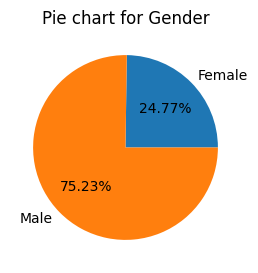

Chi2 test between Gender and Disease have chi2 statistics value = 2.49 and p_value of 0.11
----------------------------------------------------------------
+---------+--------------------+------------------+-------+------------+
| Ethnic  | Have Liver Disease | No liver disease |  All  | percentage |
+---------+--------------------+------------------+-------+------------+
| Chinese |       110.0        |       29.0       | 139.0 |   25.14    |
| Indian  |        93.0        |       46.0       | 139.0 |   25.14    |
|  Malay  |       180.0        |       95.0       | 275.0 |   49.73    |
|   All   |       383.0        |      170.0       | 553.0 |   100.0    |
+---------+--------------------+------------------+-------+------------+


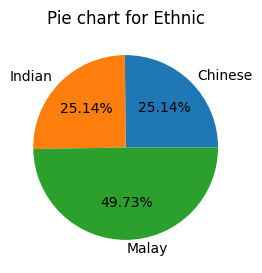

Chi2 test between Ethnic and Disease have chi2 statistics value = 8.60 and p_value of 0.01
----------------------------------------------------------------
+------------+--------------------+------------------+-------+------------+
|    bmi     | Have Liver Disease | No liver disease |  All  | percentage |
+------------+--------------------+------------------+-------+------------+
| Normal BMI |        70.0        |      128.0       | 198.0 |    35.8    |
| Overweight |       313.0        |       42.0       | 355.0 |    64.2    |
|    All     |       383.0        |      170.0       | 553.0 |   100.0    |
+------------+--------------------+------------------+-------+------------+


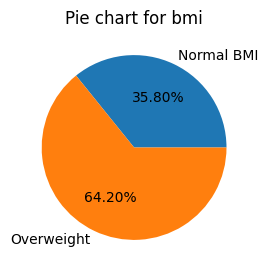

Chi2 test between bmi and Disease have chi2 statistics value = 164.06 and p_value of 0.00
----------------------------------------------------------------
Descriptive Analysis for dependent variables:
+--------------------+-------+
|      Disease       | count |
+--------------------+-------+
| Have Liver Disease |  383  |
|  No liver disease  |  170  |
|        All         |  553  |
+--------------------+-------+


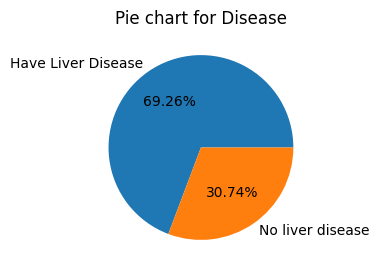

The summary of the statistical tests for independent variable:
+---+----------------------+-----------+------------------+----------+
|   | independent_variable | test_name | statistic_values | p_values |
+---+----------------------+-----------+------------------+----------+
| 0 |        Gender        | Chi2 Test |       2.49       |   0.11   |
| 1 |        Ethnic        | Chi2 Test |       8.6        |   0.01   |
| 2 |         bmi          | Chi2 Test |      164.06      |   0.0    |
+---+----------------------+-----------+------------------+----------+
The chi2 test is positive and indicate there is an association between Disease and Ethnic, bmi.
The chi2 test is negative and indicate there is no association between Disease and Gender
-----------------------------------------------------------
For dependent variable:
+--------------------+-------+------------+
|      Disease       | count | percentage |
+--------------------+-------+------------+
| Have Liver Disease | 383.0 |   69.26

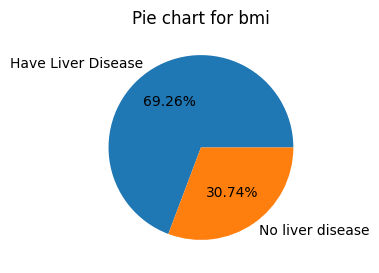

In [8]:
# Reverse Encode
data = mphd.categorical_data.reverse_encode(df = df, json_dict=data_dictionary)

# Categegorical Data Analysis
categorical_summary = mphd.categorical_data.categorical_descriptive_analysis(data,
                                                                             independent_variables = independent_categorical, 
                                                                             dependent_variables = dependent_variable, 
                                                                             analyse_dependent = True)

## Model Training

In [9]:
# Train Test Split
X_train, X_test, y_train, y_test = mphd.pre_processing.train_test_split(df = df,
                                                                        independent_variables=independent_variables,
                                                                        dependent_variable = dependent_variable,
                                                                        test_size = 0.2)

## For Light Gradient Boost Machine

In [10]:
# LightGBM
lgbm_params = {'classifier__max_depth': [3,4,5],
               'classifier__learning_rate' : [0.1, 0.2],
               'classifier__min_child_weight' : range(1,3,1),
               'classifier__boosting_type' : ['gbdt'],
               'smote__sampling_strategy': np.linspace(0.5, 0.9, 2),
               'classifier__reg_alpha':[1e-5,0.01,0.03],
               'classifier__num_leaves':[6]}

LightGBM_grid_search, LightGBM_time_required = mphd.machine_learning.LightGBM(X_train = X_train, y_train = y_train,
                                                            params = lgbm_params,
                                                            independent_variables_continous = independent_continous)

[LightGBM] [Info] Number of positive: 245, number of negative: 122
[LightGBM] [Info] Number of positive: 245, number of negative: 122
[LightGBM] [Info] Number of positive: 245, number of negative: 122
[LightGBM] [Info] Number of positive: 245, number of negative: 122
[LightGBM] [Info] Number of positive: 244, number of negative: 122
[LightGBM] [Info] Number of positive: 244, number of negative: 219
[LightGBM] [Info] Number of positive: 245, number of negative: 220
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 504
[LightGBM] [Info] Total Bins 489[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_col_wise=true` to r

Best Params:
{'classifier__boosting_type': 'gbdt',
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 4,
 'classifier__min_child_weight': 2,
 'classifier__num_leaves': 6,
 'classifier__reg_alpha': 0.03,
 'smote__sampling_strategy': 0.5}
------------------------------------------------


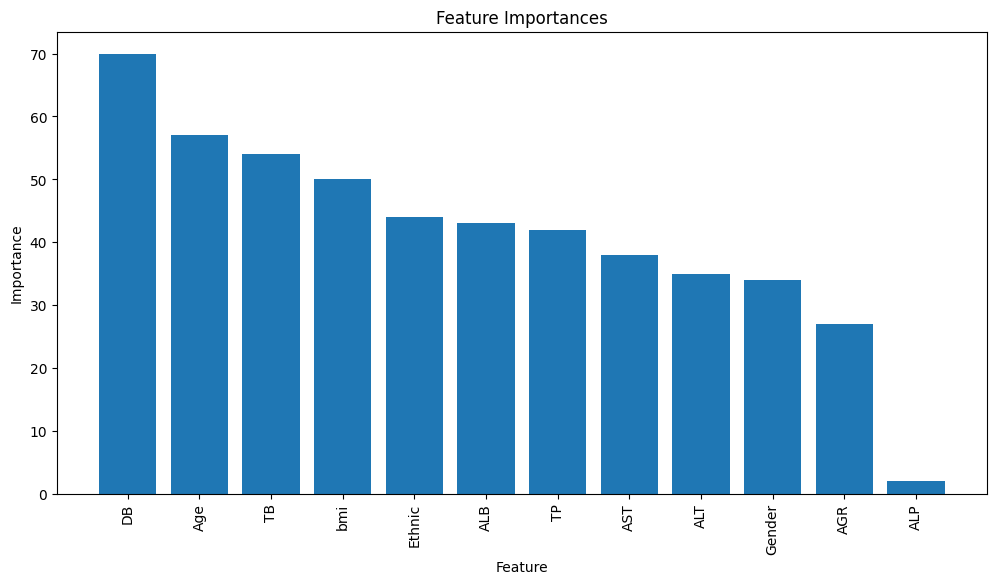

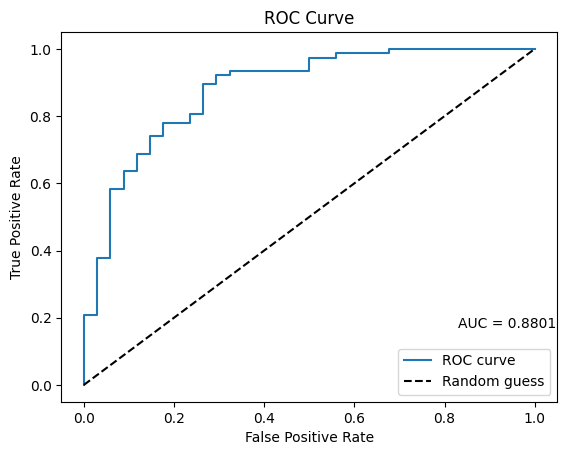

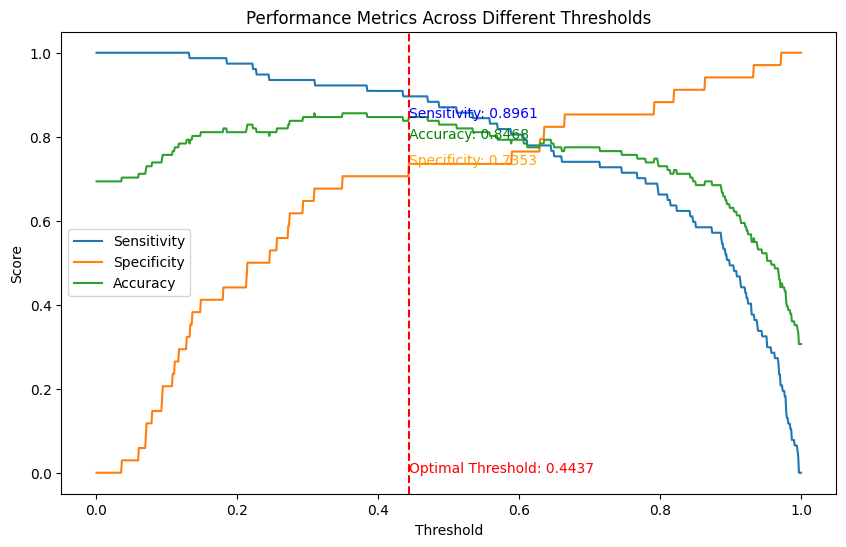

Confusion Matrix:
+-----------------+--------------------+------------------+-----+
|    Condition    | Correct_Prediction | Wrong_Prediction | All |
+-----------------+--------------------+------------------+-----+
| False Condition |         9          |        25        | 34  |
| True Condition  |         69         |        8         | 77  |
|       All       |         78         |        33        | 111 |
+-----------------+--------------------+------------------+-----+
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        34
           1       0.88      0.90      0.89        77

    accuracy                           0.85       111
   macro avg       0.82      0.82      0.82       111
weighted avg       0.85      0.85      0.85       111



,model_type,time_required,accuracy_score,precision_score,recall_score,f1_score,cv_score,test_score,auc,optimal_threshold,optimal_sensitivity,optimal_specificity,optimal_accuracy,max_youden_s_index
0,LightGBM,27.982298,0.846847,0.884615,0.896104,0.890323,0.831814,0.880061,0.880061,0.443722,0.896104,0.735294,0.735294,0.631398


In [11]:
# Perform analysis on LightGBM
lightgbm_summary_df = mphd.analyse_ml.analyse_ml(LightGBM_grid_search,
                                                 time_required = LightGBM_time_required,
                                                 model_type = "LightGBM",
                                                 independent_variables=independent_variables,
                                                 X_test=X_test, y_test=y_test)
lightgbm_summary_df

## For Ramdon Forest

In [12]:
# Prepare Random Forest Params
rf_params = {'classifier__max_depth':[7],
              'smote__sampling_strategy': [0.8],
              'classifier__min_samples_split':[10],
              'classifier__max_features':[0.8],
              'classifier__criterion':["entropy"],
              'classifier__bootstrap':[True],
              'classifier__n_estimators':[200],
              'classifier__min_samples_leaf':[8]}

random_forest_grid_search, random_forest_time_required = mphd.machine_learning.random_forest(X_train = X_train, y_train = y_train,
                                                                               params = rf_params, random_seed = 11)

Time taken: 1.221 seconds


Best Params:
{'classifier__bootstrap': True,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 7,
 'classifier__max_features': 0.8,
 'classifier__min_samples_leaf': 8,
 'classifier__min_samples_split': 10,
 'classifier__n_estimators': 200,
 'smote__sampling_strategy': 0.8}
------------------------------------------------


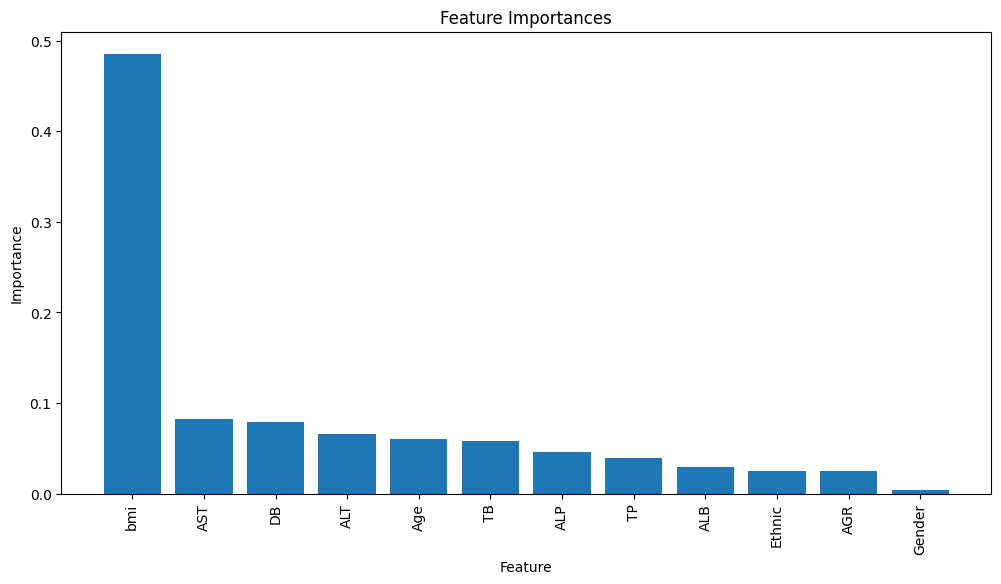

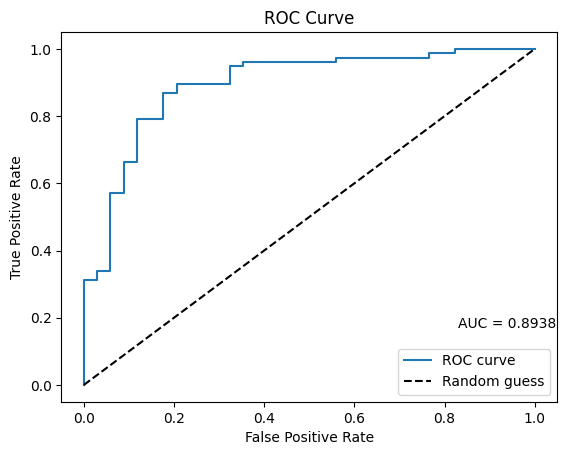

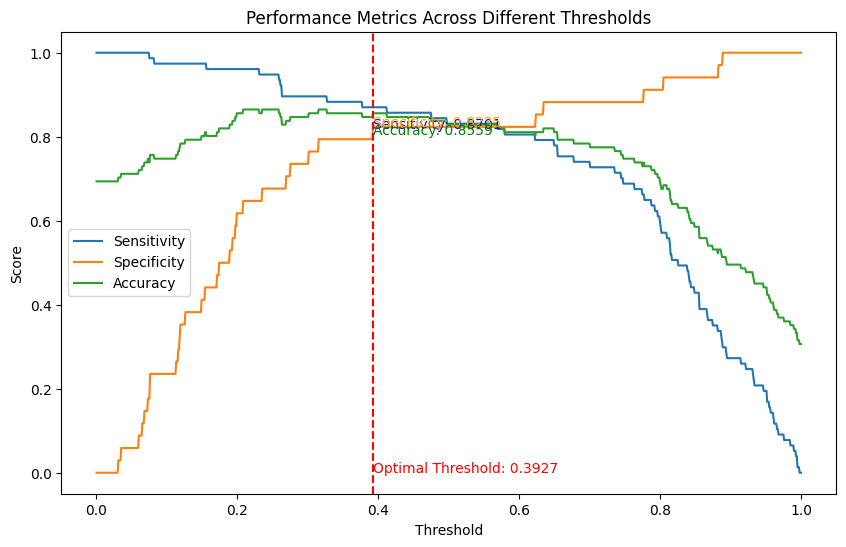

Confusion Matrix:
+-----------------+--------------------+------------------+-----+
|    Condition    | Correct_Prediction | Wrong_Prediction | All |
+-----------------+--------------------+------------------+-----+
| False Condition |         6          |        28        | 34  |
| True Condition  |         67         |        10        | 77  |
|       All       |         73         |        38        | 111 |
+-----------------+--------------------+------------------+-----+
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        34
           1       0.92      0.87      0.89        77

    accuracy                           0.86       111
   macro avg       0.83      0.85      0.84       111
weighted avg       0.86      0.86      0.86       111



,model_type,time_required,accuracy_score,precision_score,recall_score,f1_score,cv_score,test_score,auc,optimal_threshold,optimal_sensitivity,optimal_specificity,optimal_accuracy,max_youden_s_index
0,Random Forest,1.221149,0.855856,0.917808,0.87013,0.893333,0.83439,0.893812,0.893812,0.392696,0.87013,0.823529,0.823529,0.693659


In [13]:
# Perform analysis on Random Forest
rf_summary_df = mphd.analyse_ml.analyse_ml(random_forest_grid_search,
                                           time_required = random_forest_time_required,
                                           model_type = "Random Forest",
                                           independent_variables=independent_variables,
                                           X_test=X_test, y_test=y_test)
rf_summary_df

In [ ]:
def random_forest(X_train:pd.DataFrame,
                      y_train:str|list|tuple|None,
                      params:dict,
                      scoring:str = "roc_auc",
                      n_jobs:int = -1,
                      n_splits:int = 5,
                      random_seed:int|None = None):
        # Import the necessary packages
        from ..pre_processing.pre_processing import pre_processing
        from sklearn.ensemble import RandomForestClassifier
        from imblearn.pipeline import Pipeline
        from imblearn.over_sampling import SMOTE
        from sklearn.model_selection import GridSearchCV, StratifiedKFold
        import time

        pipeline = Pipeline(steps = [['smote', SMOTE(random_state=random_seed)],
                                     ['classifier', RandomForestClassifier()]])


        stratified_kfold = StratifiedKFold(n_splits=n_splits,
                                           shuffle=True,
                                           random_state=random_seed)
        
        grid_search = GridSearchCV(estimator=pipeline,
                                   param_grid=params,
                                   scoring=scoring,
                                   cv=stratified_kfold,
                                   n_jobs=n_jobs)
        
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        end_time = time.time()
        time_required = end_time - start_time
        print(f'Time taken: {end_time - start_time:.3f} seconds')

        return grid_search, time_required